<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/bia/lab5/BIA_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal component analysis (PCA)

We start by building a simple 3D dataset:

In [ ]:
import numpy as np

np.random.seed(4)
n = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(n) * 3 * np.pi / 2 - 0.5
X = np.empty((n, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(n) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(n) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(n)

To do **principal component analysis (PCA)**, we can use *singular value decomposition (SVD)*, which is available in `numpy` via the `svd()` function. We can use it to obtain all the **principal components (PC)** of the training set, and then extract the two unit vectors that define the first two PCs:

In [ ]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA assumes that the dataset is *centered* around the origin. As we will see, `scikit-learn`’s `PCA` class takes care of centering the data for us. If we implement PCA ourselves (as in the preceding example), or if we use other libraries, we have to center the data first.

We can verify the correctness of the SVD using the `allclose()` function in `numpy`, which returns `True` if two arrays are element-wise equal within a tolerance. Note that the `svd()` function returns an array, so, in order to transform it into a matrix, we have to use the `numpy` function `diag()`.

In [ ]:
n, d = X.shape

S = np.zeros(X_centered.shape)
S[:d, :d] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Once we have identified all the principal components, we can reduce the dimensionality of the dataset down to $l$ dimensions by projecting it onto the hyperplane defined by the first $l$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{l\text{-proj}}$ of dimensionality $l$, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_{l}$, defined as the matrix containing the first $l$ columns of $V$, as follows: $X_{l\text{-proj}}=XW_{l}$.

The following code projects the training set onto the plane defined by the first
two principal components.

In [ ]:
W2 = Vt.T[:, :2]
X2D_using_svd = X_centered.dot(W2)

Now, let's see how to do PCA using `scikit-learn`. `scikit-learn`’s `PCA` class uses SVD decomposition to implement PCA, just like we did earlier. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions, specified by the `n_components=2` parameter. Note that it automatically takes care of centering the data. We can call the `fit_transform()` method, which will build the model and immediately return the transformed data.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

Notice that running PCA multiple times on slightly different datasets may result in different results. In general, the only difference is that some axes may be flipped. In this example, `PCA` using `scikit-learn` gives the same projection as the one given by the SVD approach in `numpy`, except both axes are flipped.

In [ ]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [ ]:
np.allclose(X2D, -X2D_using_svd)

True

We can transform the data back to the original space, obtaining $\hat{X}$. This can be done via the `inverse_transform()` function.

In [ ]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points.

In [ ]:
np.allclose(X3D_inv, X)

False

We can compute the **reconstruction error**:

In [ ]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

We can compute the inverse transform using the SVD approach by: $\hat{X}=X_{l\text{-proj}}W_{l}^\top$, where, as before, $W_{l}$ is defined as the matrix containing the first $l$ columns of $V$.

In [ ]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because `scikit-learn`'s `PCA` class automatically takes care of reversing the mean centering, but, if we subtract the mean (stored in the `mean_` attribute), we get the same reconstruction.

In [ ]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed, via the `components_` attribute. The `components_` attribute holds the transpose of $W_{l}$. For example, the unit vector that defines the first principal component is equal to `pca.components_.T[:, 0]`.

In [ ]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

We can compare the first two principal components with the ones computed using the SVD method.

In [ ]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice that the axes are flipped.

Another useful piece of information is the *explained variance ratio* of each principal component, available via the `explained_variance_ratio_` attribute. The ratio indicates the proportion of the dataset’s variance that lies along each principal component. For example, let’s look at the explained variance ratios of the first two components of our 3D dataset.

In [ ]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

This output tells us that 84.2% of the dataset’s variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

In [ ]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`).

In [ ]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Now, let's plot the data. First, express the plane our data lies close to as a function of x and y.

In [ ]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

We can now plot the 3D dataset, the plane, and the projections on that plane. The points below the plane (`X3D_below`) are slightly lighter in color, specified by the `alpha=0.5` attribute.

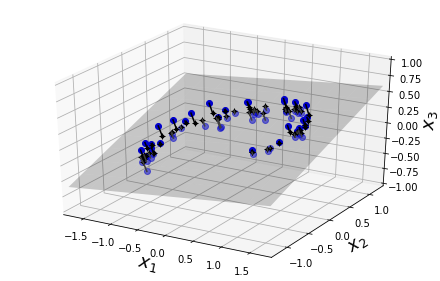

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

#plot the points above and below the plane
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

#plot the plane
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")

#plot the projections on the plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

#plot the lines connecting the 3D points with their projections on the plane
for i in range(n):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

We can also plot the projection of the dataset on the plane. Note that the axes correspond to new features $z_1$ and $z_2$ (the coordinates of the projections on the plane).

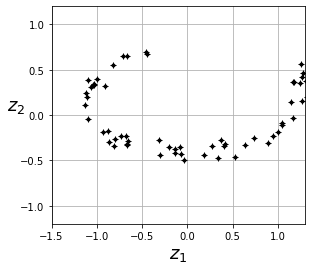

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

Now, let's apply PCA to perform compression on a real world dataset, MNIST. The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello, world!” of machine learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.

Each image of the 70,000 images in the dataset has 784 features. This is because each image is $28 \times 28$ pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

`scikit-learn` provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from the [OpenML](https://www.openml.org/) online repository. Since `scikit-learn` 0.24, `fetch_openml()` returns a `pandas` `DataFrame` by default. To avoid this and return a `numpy` array, we set `as_frame=False`. (Be patient, it will take a while.)

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

Now, we split the data into the train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%). Unless, of course, we are reducing dimensionality for data visualization — in which case we will want to reduce the dimensionality down to 2 or 3.

The following code performs PCA on the training set of MNIST without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance.

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
l = np.argmax(cumsum >= 0.95) + 1

In [ ]:
l

154

We can see that just 154 components are necessary in order to preserve 95% of the training set’s variance.

We could then set `n_components=l`, and run PCA again. But there is a much better option: instead of specifying the number of principal components we want to preserve, we can set `n_components` to be a float between 0.0 and 1.0, indicating the ratio of variance we wish to preserve.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

We obtained the same number of components. We can verify that indeed at least 95% of the variance is preserved.

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

We found that each instance will have just over 150 features, while preserving 95% of the variance, instead of the original 784 features. So, while most of the variance is preserved, the dataset is now less than 20% of its original size. This is a reasonable compression ratio, and we can see how this size reduction can speed up a classification algorithm (such as an SVM classifier) tremendously.

We can also decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This will not yield the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data.

The following code compresses the MNIST dataset down to 154 dimensions, then
uses the `inverse_transform()` method to decompress it back to 784 dimensions.

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

The figure below shows a few digits from the original training set (on the left), and the corresponding digits after compression and decompression. We can see that there is a slight image quality loss, but the digits are still mostly intact.

In [ ]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary)
    plt.axis("off")

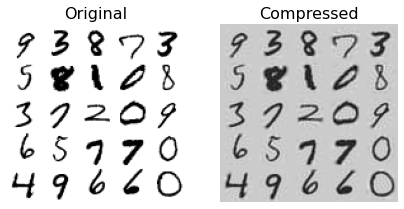

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

# Locally linear embedding (LLE)

Projection is not always the best approach to dimensionality reduction. In
many cases, the subspace may twist and turn, such as in the famous *Swiss roll* toy dataset, represented in the figure below. The dataset can be generated using the `make_swiss_roll()` method in `scikit-learn`.

In [ ]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

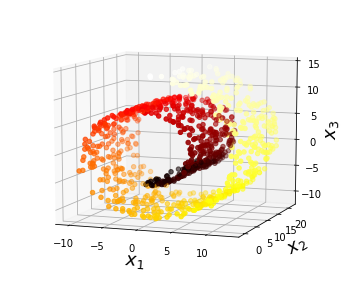

In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Simply projecting onto a plane (e.g., by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left side of the figure below. What we really want is to unroll the Swiss roll to obtain the 2D dataset on the right side of the figure below.

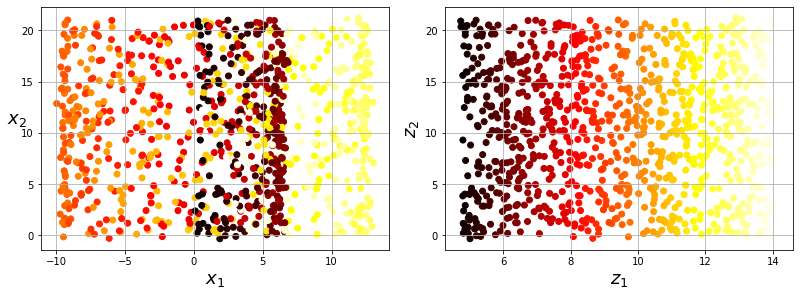

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4), constrained_layout=True)

plt.sca(axes[0])
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.sca(axes[1])
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

plt.show()

**Locally linear embedding (LLE)** is a powerful *nonlinear dimensionality reduction (NLDR)* technique. It is a *manifold learning* technique that does not rely on projections, like the PCA algorithm does. In a nutshell, LLE works by first measuring how each training instance linearly relates to its *closest neighbors*, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code uses `scikit-learn`’s `LocallyLinearEmbedding` class to unroll the Swiss roll. Just as with `PCA`, we have to specify the dimensionality of the low-dimensional representation, using the `n_components` parameter, and the number of closest neighbors, using the `n_neighbors` parameter.

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

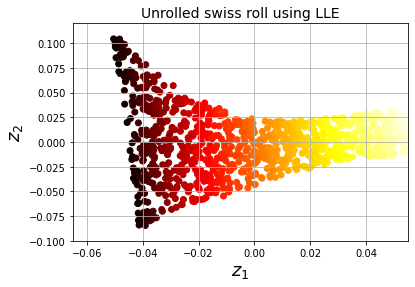

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# t-Distributed stochastic neighbor embedding (t-SNE)

The **t-Distributed stochastic neighbor embedding (t-SNE)** algorithm reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize
clusters of instances in high-dimensional space.

The class in `scikit-learn` implementing this algorithm is `TSNE`. In order to apply it to the Swiss roll dataset, we just have to specify the dimensionality of the low-dimensional representation, using the `n_components` parameter.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


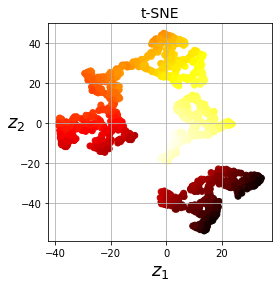

In [ ]:
plt.figure(figsize=(4,4))

plt.title("t-SNE", fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

We can see that the points in the embedding space act like stars and galaxies, forming many well-separated clusters (galaxies), each of which having many stars tightly packed inside.

We will now apply the t-SNE manifold learning algorithm on a dataset of handwritten digits that is included in `scikit-learn`, which is different and much simpler than the MNIST dataset. Each data point in this dataset is an $8\times 8$ grayscale image of a handwritten digit between 0 and 9. The figure below shows an example image for each class.

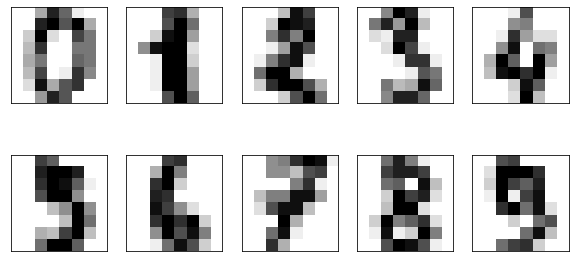

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, cmap=mpl.cm.binary)

Let’s use PCA to visualize the data reduced to two dimensions. We plot the first two principal components, and color each dot by its class.

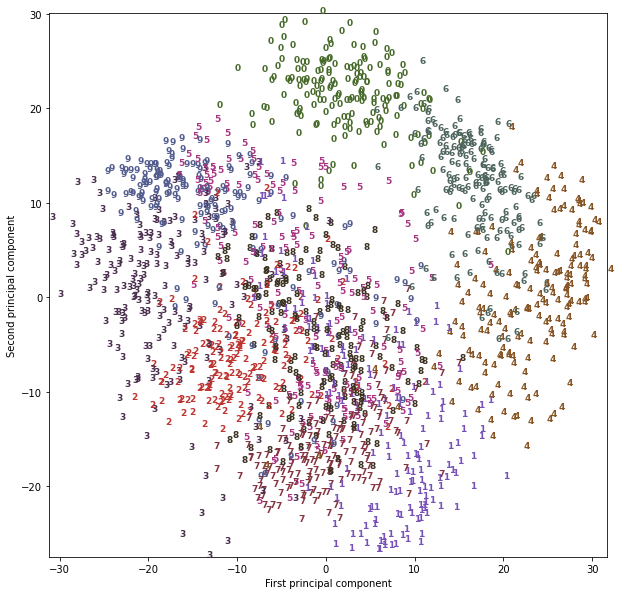

In [ ]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)
# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

Here, we actually used the true digit classes as glyphs, to show which class is where. The digits zero, six, and four are relatively well separated using the first two principal components, though they still overlap. Most of the other digits overlap significantly.

Let’s apply t-SNE to the same dataset, and compare the results.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


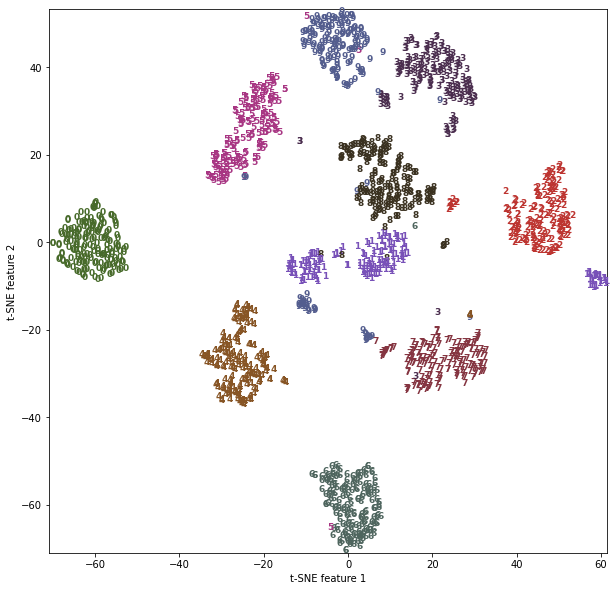

In [ ]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

The result of t-SNE is quite remarkable. All the classes are quite clearly separated. The ones and nines are somewhat split up, but most of the classes form a single dense group. Keep in mind that this method has no knowledge of the class labels: it is completely unsupervised. Still, it can find a representation of the data in two dimensions that clearly separates the classes, based solely on how close points are in the original space.